# Creating the toxicity index, doing a classification task, interpreting and debugging the model 

This notebook transforms the regression problem into a classification problem by creating a Toxicity index.
- After several attempts, the group agreed on the following statement :A toxic Youtube comment feed is a feed containing:
        - Toxic Interactivity : number of replied comment is at least 2 times the number of top comments, which means people are interacting with someone who has written something, percentage of insulting words higher than 1%
OR
        - great amount of insults percentage in general: higher than 5%
Of course, there are several other ways to deal with the problem, we have espcially tried another configuration, but it led to too few examples to train thus we have retained the above statement.

-  We perform a classification comparison Pipeline with the following specifities: 
    - Crossvalidation = 5 folds with stratification 
    - Mean encoding for the categorical data with respect to the crossvalidation in order to avoid data leakage (the mean enconding has given better results than One hot encoding)
    - A comparison of using only the samples VS performing an oversampling of the rare class, with the respect of crossvalidation, the algorithm used is the SMOTE https://arxiv.org/pdf/1106.1813.pdf 
    - The models that we compare are the following : 
            - Logistic regression, KNN, Xgboost, Random forest and Light GBM. The Support vector Machine classifier took too much time to compute and everytime it crashed our Kernel.
            - We scale the features before feeding them into the logistic regression and KNN. There is no need for preprocessing for the tree based models
    - The metric used for comparison is the f1 score, because we are in an imbalance class problem. Furthermore we will give the same importance to recall and precision.
    - We will also delete an important feature in order for us to see how much it is important, and after that we will try to do some fine tuning for hyper parameters of the best model in order to reach acceptable performances without this feature.
    - We will finally reuse the feature and do some model debugging and interpretability techniques to interpret the model's decisions; we advice you to take a look at the package insepction of scikit learn to know more about that and to take a lot at the research paper we shared to go further in model interpretation ;) 
    

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.inspection import partial_dependence, plot_partial_dependence
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve,
    fbeta_score,
    make_scorer
)
import pandas as pd


In [3]:
def load_format_dataset(path='challenge_youtube_toxic.csv'):
    df = pd.read_csv(path,encoding='iso-8859-1',  delimiter=";",error_bad_lines=False )
    df = df.drop(['Unnamed: 27'],1)
    for i in df.columns:
        if (i.startswith('nbr') & (df[i].dtype=='O')):
            df[i] = df[i].apply(lambda x: float(x.replace(',','.')))
    
    return df.drop(['video_id_court', 'video_id','channel_id'],1)

In [4]:
def create_toxicity_dataset(df):
    
    def create_toxicity_index(df):
        condition_0 = df['nbrMot']==0
        if condition_0:
            return 0
        else:
            condition_1 = ((df['comment_count']/df['thread_count'])>=2)and((df['nbrMotInsulte']/ df['nbrMot'])>0.01)
            condition_2 = (df['nbrMotInsulte']/ df['nbrMot'])>0.05
            if (condition_1 or condition_2):
                return 1
            else:
                return 0
    df['Toxicity_index'] = df.apply(lambda x: create_toxicity_index(x), axis=1)
    df = df.drop(['nbrMotInsulte','channel_name'],1)
    return df

In [5]:
def mean_encoding(df_train, df_test):
    for name_categorical_column in df_train.dtypes[df_train.dtypes=='object'].index.tolist():
        Mean_encoded_subject = df_train.groupby([name_categorical_column])['Toxicity_index'].mean().to_dict() 
        df_train[name_categorical_column] =  df_train[name_categorical_column].map(Mean_encoded_subject)
        df_test[name_categorical_column] =  df_test[name_categorical_column].map(Mean_encoded_subject)
    return df_train, df_test

In [6]:
def crossvalidation_oversampling_mixed_data(df):
    pipelines = []
    pipelines.append(("ScaledLR",Pipeline([("Scaler", StandardScaler()), ("LR", LogisticRegression())])))
    pipelines.append(("ScaledKNN",Pipeline([("Scaler", StandardScaler()), ("KNN", KNeighborsClassifier())])))
    pipelines.append(("XGB", XGBClassifier()))
    pipelines.append(("RF", RandomForestClassifier()))
    pipelines.append(("LGBM", LGBMClassifier()))
    results = []
    results_resample = []
    names = []
    
    for name, model in pipelines:
        cv_results_resample = []
        cv_results = []
        kfold = KFold(n_splits=5, random_state=21)
        for train_index, test_index in kfold.split(df):
            oversample = SMOTE()
            df_train, df_test = mean_encoding(df.iloc[train_index,:], df.iloc[test_index,:])
            X, y = oversample.fit_resample(df_train.iloc[:,:-1], df_train.iloc[:,-1])
            model.fit(X, y)
            cv_results_resample.append(f1_score(df_test.iloc[:, -1],model.predict(df_test.iloc[:, :-1])))
            model.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
            cv_results.append(f1_score(df_test.iloc[:, -1],model.predict(df_test.iloc[:, :-1])))

        results.append(cv_results)
        results_resample.append(cv_results_resample)
        names.append(name)
    fig, ax = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(15, 10)
    ax[0].boxplot(results)
    ax[0].set_xticklabels(names)
    ax[0].set_title("normal")
    ax[1].boxplot(results_resample)
    ax[1].set_xticklabels(names)
    ax[1].set_title("oversampling")
    fig.suptitle("Model Comparison for the f1 score without/with resampling")
    return names, results, results_resample

In [8]:
def show_classification_results(classifier, x_test, y_test, beta = 1):
    y_pred_test = classifier.predict(x_test)
    report = classification_report(y_true=y_test, y_pred=y_pred_test)
    matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
    print("Test Set:")
    print(report)
    print('F-{} score is : {}'.format(beta,fbeta_score(y_test, y_pred_test,beta)))
    df_cm = pd.DataFrame(
        matrix, index=[i for i in "01"], columns=[i for i in "01"]
    )
    plt.figure(figsize=(7, 5))
    plt.xlabel("Real class")
    plt.ylabel("Predicted class")
    ax = sns.heatmap(df_cm, annot=True, color="blue")
    ax.set(xlabel="real class", ylabel="predicted class")

## 1- Is using oversampling better ? 

In [44]:
df = create_toxicity_dataset(load_format_dataset())
kfold = KFold(n_splits=5, random_state=21)
for train_index, test_index in kfold.split(df):
    oversample = SMOTE()
    df.iloc[train_index,:], df.iloc[test_index,:] = mean_encoding(df.iloc[train_index,:], df.iloc[test_index,:])
    X, y = oversample.fit_resample(df.iloc[train_index,:-1], df.iloc[train_index,-1])
    LogisticRegression().fit(X,y)

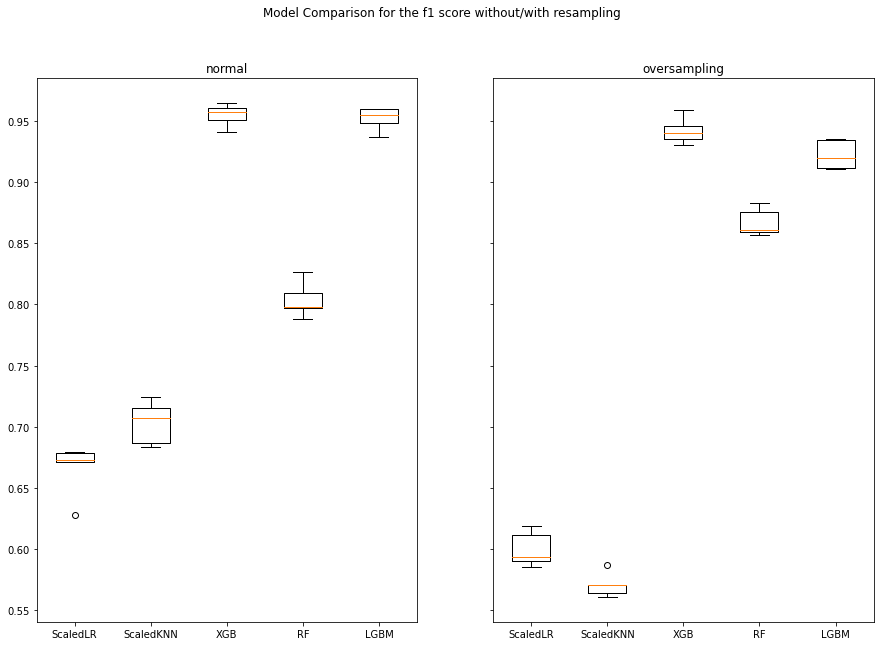

In [46]:
names, results, results_resample = crossvalidation_oversampling_mixed_data(df)

####  In both cases XGBOOST is the best classifier. We will focus on it 
Furthermore creating synthetic samples using techniques like SMOTE doesn't always give the best performances. An alternative can be doing sample weighting by giving more weights to the observations of the rare class. 

In [52]:
df['Toxicity_index'].value_counts()/len(df)

0    0.943451
1    0.056549
Name: Toxicity_index, dtype: float64

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10907
           1       0.97      0.94      0.96       619

    accuracy                           1.00     11526
   macro avg       0.99      0.97      0.98     11526
weighted avg       1.00      1.00      1.00     11526

F-1 score is : 0.9555189456342669


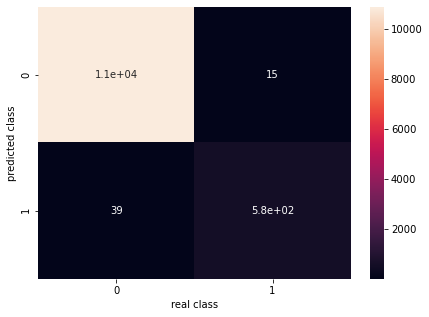

In [10]:
df_train, df_test = train_test_split(df)
df_train, df_test = mean_encoding(df_train, df_test)
model = XGBClassifier().fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
show_classification_results(model, df_test.iloc[:,:-1],df_test.iloc[:,-1])

Text(0.5, 1.0, 'ROC Curve')

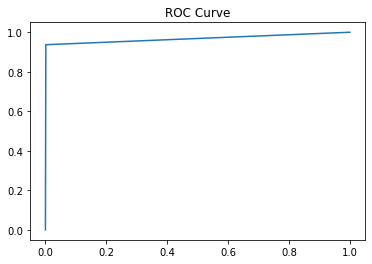

In [12]:
fpr_xgb, tpr_xgb, _  = roc_curve(df_test.iloc[:,-1], model.predict(df_test.iloc[:,:-1]))
plt.plot(fpr_xgb, tpr_xgb, label='xgboost')
plt.title('ROC Curve')

- An excellent roc curve

### 2-  What if we drop 'nbrMotInsulteMoyenne'?

<AxesSubplot:xlabel='Toxicity_index', ylabel='nbrMotInsulteMoyenne'>

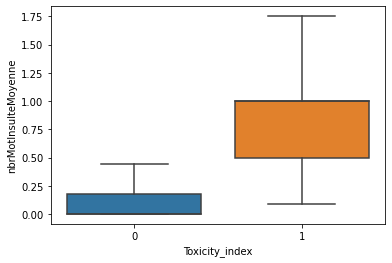

In [66]:
sns.boxplot(x='Toxicity_index',y='nbrMotInsulteMoyenne',data=df,showfliers=False)

- 'nbrMotInsulteMoyenne' seems to be a discriminative feature, so what if we drop it and see the consequences 

Test Set:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     10880
           1       0.43      0.06      0.11       646

    accuracy                           0.94     11526
   macro avg       0.69      0.53      0.54     11526
weighted avg       0.92      0.94      0.92     11526

F-1 score is : 0.10583446404341927


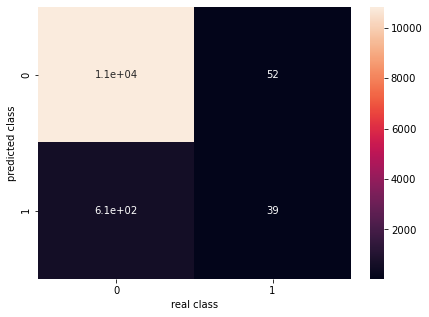

In [14]:
df_train, df_test = train_test_split(df.drop([ 'nbrMotInsulteMoyenne'],1))
df_train, df_test = mean_encoding(df_train, df_test)
model = XGBClassifier().fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
show_classification_results(model, df_test.iloc[:,:-1],df_test.iloc[:,-1])

- A very high drop in the performances ...

#### What if we use some weights in XGBoost for the rare class in order to penalize more the model if it doesn't do well on the rare class ?

Test Set:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     10848
           1       0.18      0.37      0.25       678

    accuracy                           0.87     11526
   macro avg       0.57      0.64      0.59     11526
weighted avg       0.91      0.87      0.89     11526

F-1 score is : 0.24648229015041245


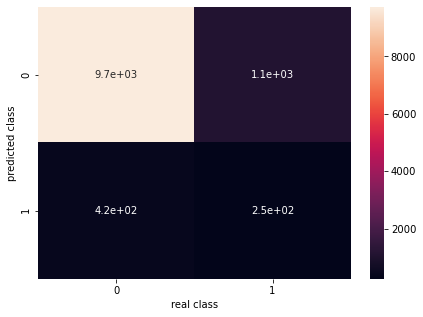

In [15]:
df_train, df_test = train_test_split(df.drop([ 'nbrMotInsulteMoyenne'],1))
df_train, df_test = mean_encoding(df_train, df_test)
model = XGBClassifier(scale_pos_weight = 10).fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
show_classification_results(model, df_test.iloc[:,:-1],df_test.iloc[:,-1])

- let's fine tune the parameters of xgboost so it can reach the best performances of f1 score

### 3- Let's do some fine tuning 

In [80]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'scale_pos_weight':[5,8,10,15,20]
}

In [83]:
clf = GridSearchCV(XGBClassifier(), params, n_jobs=5, cv=5,scoring=make_scorer(fbeta_score, beta=1),verbose=2, refit=True)

In [85]:
df_train, df_test = train_test_split(df.drop([ 'nbrMotInsulteMoyenne'],1))
df_train, df_test = mean_encoding(df_train, df_test)

In [86]:
clf.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])

Fitting 5 folds for each of 2025 candidates, totalling 10125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   12.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   52.6s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed:  9.8min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed: 17.5min
[Parallel(n_jobs=5)]: Done 3271 tasks      | elapsed: 22.3min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 28.8min
[Parallel(n_jobs=5)]: Done 4891 tasks      | elapsed: 35.4min
[Parallel(n_jobs=5)]: Done 5822 tasks      | elapsed: 43.0min
[Parallel(n_jobs=5)]: Done 6835 tasks      | elapsed: 51.4min
[Parallel(n_jobs=5)]: Done 7928 tasks      | elapsed: 61.4min
[Parallel(n_jobs=5)]: Done 9103 tasks      | elapsed: 71.9min

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

In [92]:
print('Best parameters : {}, best score : {}'.format(clf.best_params_,clf.best_score_))

Best parameters : {'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 3, 'min_child_weight': 10, 'scale_pos_weight': 15, 'subsample': 1.0}, best score : 0.3861232227486774


- Thanks to using GridSearch we have raised our f1 score from 0.1 to 0.386 

### 4- let's reuse all the features and do some model diagnosis and interpretability 

In [17]:
df_train, df_test = train_test_split(df)
df_train, df_test = mean_encoding(df_train, df_test)
model = XGBClassifier().fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])

Text(0.5, 1.0, 'the number of times a feature appears in a tree')

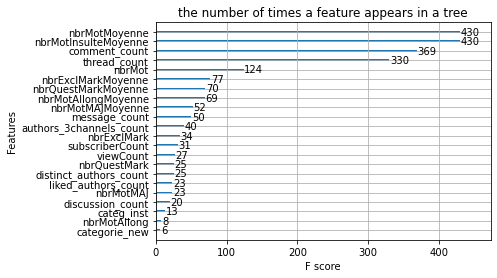

In [21]:
plot_importance(model,importance_type='weight')
plt.title('the number of times a feature appears in a tree')

Text(0.5, 1.0, 'the average gain of splits which use the feature')

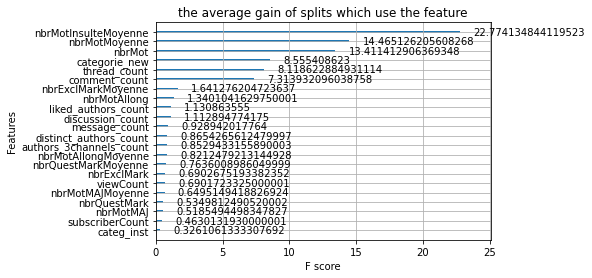

In [22]:
plot_importance(model,importance_type='gain')
plt.title('the average gain of splits which use the feature')

In [27]:
df_train.columns

Index(['nbrMot', 'nbrMotAllong', 'nbrMotMAJ', 'nbrExclMark', 'nbrQuestMark',
       'nbrMotMoyenne', 'nbrMotInsulteMoyenne', 'nbrMotAllongMoyenne',
       'nbrMotMAJMoyenne', 'nbrExclMarkMoyenne', 'nbrQuestMarkMoyenne',
       'thread_count', 'comment_count', 'message_count', 'discussion_count',
       'distinct_authors_count', 'authors_3channels_count',
       'liked_authors_count', 'subscriberCount', 'viewCount', 'categorie_new',
       'categ_inst', 'Toxicity_index'],
      dtype='object')

In [ ]:
df[['nbrMotInsulteMoyenne','nbrMotMoyenne','nbrMot','categorie_new',
    'thread_count','comment_count', 'nbrExclMarkMoyenne']]

- When combining the two feature importance plots, we come to the following conclusions :
    - NbrInsulteMoyenne is the feature that brings the more gain into the model and is the most present in the trees
    - eventhough categorie_new doesn't appear in a lot of trees, it brings a lot of gain when it does 
- Let's take the top 7 features in terms of gain and see if it drops the performances of the model 

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10908
           1       0.97      0.93      0.95       618

    accuracy                           0.99     11526
   macro avg       0.98      0.96      0.97     11526
weighted avg       0.99      0.99      0.99     11526

F-1 score is : 0.9486754966887417


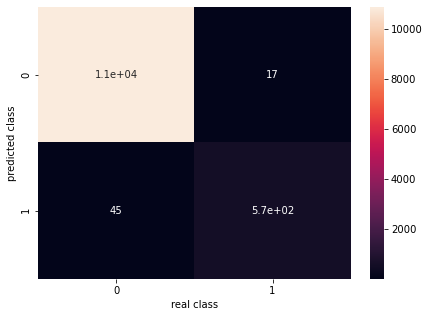

In [24]:
show_classification_results(model, df_test.iloc[:,:-1],df_test.iloc[:,-1])

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10908
           1       0.97      0.95      0.96       618

    accuracy                           1.00     11526
   macro avg       0.98      0.97      0.98     11526
weighted avg       1.00      1.00      1.00     11526

F-1 score is : 0.9590834697217675


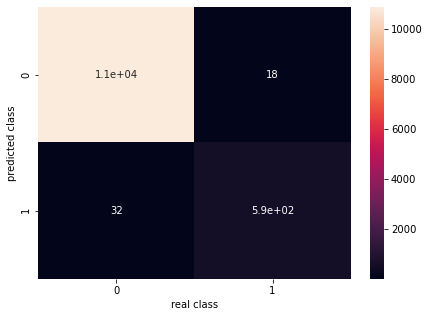

In [29]:
model2 = XGBClassifier().fit(df_train[['nbrMotInsulteMoyenne','nbrMotMoyenne','nbrMot','categorie_new',
    'thread_count','comment_count', 'nbrExclMarkMoyenne']],df_train['Toxicity_index'])
show_classification_results(model2, df_test[['nbrMotInsulteMoyenne','nbrMotMoyenne','nbrMot','categorie_new',
    'thread_count','comment_count', 'nbrExclMarkMoyenne']],df_test['Toxicity_index'])

- This feature selection helped gain better results (from 0.948 to 0.959 in f1 score ), let's keep model2

- Other than knowing the importance of the features, it is also important to see how they act on the model output. Thus, we will use partial dependence plot, please look at the following link for more information about it : https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence 
- Partial dependence is not the most rigorous way to analyze the impact of a feature on an output ( there are other state of the art model agnostic techniques to have more accurate interpretations, especially the ones that rely on Game theory , We let you consult this **wonderful** research paper !! https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf )

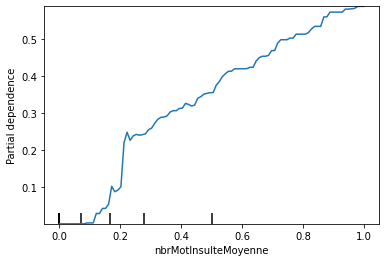

In [34]:
plot_partial_dependence(model2, df_test[['nbrMotInsulteMoyenne','nbrMotMoyenne','nbrMot','categorie_new',
    'thread_count','comment_count', 'nbrExclMarkMoyenne']], ['nbrMotInsulteMoyenne'])
plt.show()

- The more the mean number of insults grows the more the probability of a video feed to be toxic.
- It is also good to see that the interval impact of this feature on the output is important( about 0.6 )

In [35]:
features = ['nbrMotInsulteMoyenne','nbrMotMoyenne','nbrMot','categorie_new',
    'thread_count','comment_count', 'nbrExclMarkMoyenne']

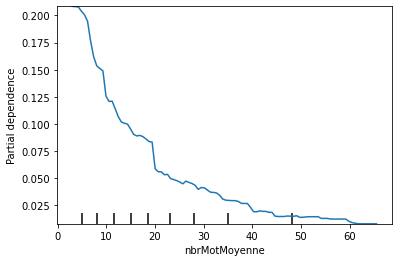

In [48]:
plot_partial_dependence(model2, df_test[features], ['nbrMotMoyenne'])
plt.show()

- Oppositely, the more you have words in a comment the less a youtube video feed is toxic, the interpretation would be that generally when we have a long comment, we tend to explain something, or even argue about something but with explanations and respect and not jumping into insulting someone.
- A lower impact on the output ( about 0.6 )

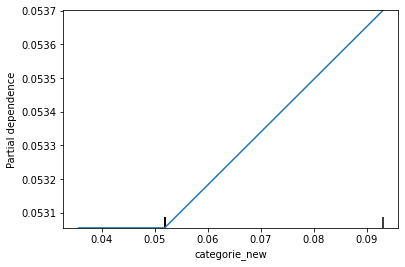

In [37]:
plot_partial_dependence(model2, df_test[features], ['categorie_new'])
plt.show()

- it is logical that we have a positive relationship since this feature was done via mean encoding 
- a little impact compared to the other features

- We can of course see the impact of other features but we will now do some model debugging

Text(0.5, 1.0, 'Density of the Probability of being a toxic youtube video feed on the test set')

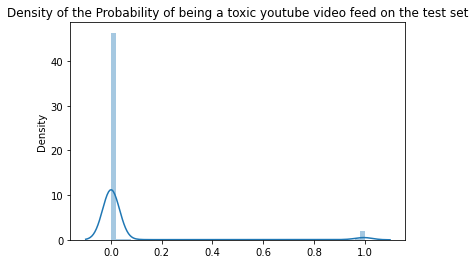

In [45]:
sns.distplot(model2.predict_proba( df_test[features])[:,-1])
plt.title('Density of the Probability of being a toxic youtube video feed on the test set')

xgboost seems to be pretty sure about its decisions (not a lot of probabilities fall into the interval [0.3-0.7])

Text(0.5, 1.0, 'Density of the Probability of being a toxic youtube video feed for the wrong classified observations')

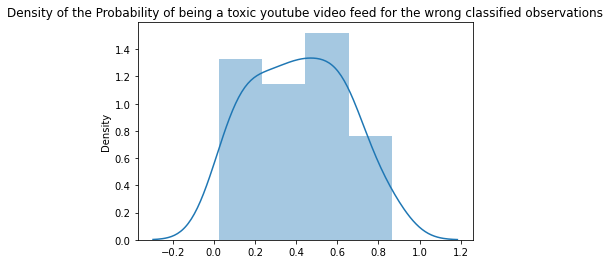

In [61]:
sns.distplot(model2.predict_proba( df_test[features])[:,-1] [np.where(model2.predict( df_test[features]) != df_test['Toxicity_index'].values)[0]])
plt.title('Density of the Probability of being a toxic youtube video feed for the wrong classified observations')

Text(0.5, 1.0, 'Density of the Probability of being a toxic youtube video feed for the good classified observations')

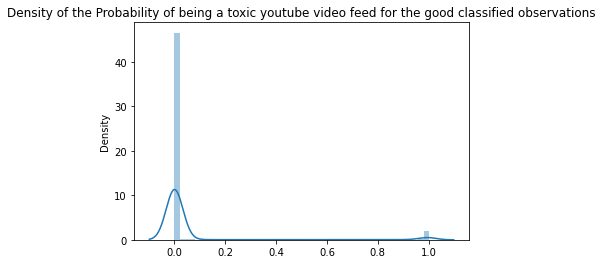

In [65]:
sns.distplot(model2.predict_proba( df_test[features])[:,-1] [np.where(model2.predict( df_test[features]) == df_test['Toxicity_index'].values)[0]])
plt.title('Density of the Probability of being a toxic youtube video feed for the good classified observations')

- We see that the distribution of the probability differs when the model is doing mistakes and when it classified well the observations

In [79]:
predict_proba = pd.DataFrame(model2.predict_proba( df_test[features])[:,-1], columns=['proba'])

In [80]:
prediction = pd.DataFrame(model2.predict(df_test[features]), columns=['prediction'])

In [81]:
real = pd.DataFrame(df_test['Toxicity_index'].values, columns=['real'])

In [82]:
model_perf = pd.concat([predict_proba,prediction,real],axis=1)

In [87]:
def print_percentage_success(model_perf, interval_a, interval_b):
    number_success = len(model_perf[(model_perf['proba']>interval_a) &(model_perf['proba']<interval_b) &(model_perf['prediction']== model_perf['real']) ])
    number_total = len(model_perf[(model_perf['proba']>interval_a) &(model_perf['proba']<interval_b) ])
    return number_success/ number_total

In [93]:
print('The percentage of success classification for the model is:')
list_percentage = list()
list_intervals= list()
for i in range(10):
    percentage_success = print_percentage_success(model_perf, i/10, (i+1)/10)
    list_percentage.append(percentage_success)
    list_intervals.append('[{}-{}]'.format(i/10,(i+1)/10))
    print('{} between the interval probability[{}-{}]'.format(percentage_success, i/10,(i+1)/10))

The percentage of success classification for the model is:
0.9995375080936083 between the interval probability[0.0-0.1]
0.8222222222222222 between the interval probability[0.1-0.2]
0.8620689655172413 between the interval probability[0.2-0.3]
0.6818181818181818 between the interval probability[0.3-0.4]
0.4666666666666667 between the interval probability[0.4-0.5]
0.7368421052631579 between the interval probability[0.5-0.6]
0.5 between the interval probability[0.6-0.7]
0.8947368421052632 between the interval probability[0.7-0.8]
0.896551724137931 between the interval probability[0.8-0.9]
1.0 between the interval probability[0.9-1.0]


let's plot it to have a better view 

Text(0.5, 1.0, 'percentage of success classifcation per probability interval')

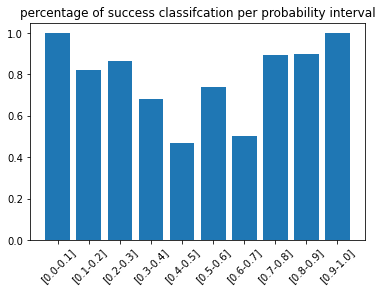

In [99]:
plt.bar(list_intervals, list_percentage)
plt.xticks(rotation='45')
plt.title('percentage of success classifcation per probability interval')

- Given a minimum accuracy threshold "Alpha", we will trust the model whenever the accuracy is higher than alpha, so for example if alpha=0.8 then whenever the model outputs a probability between [0-0.3] or [0.7-1] we will trust its decisions 
but for a probability output between [0.3-0.7] it would be preferable for example to verify manually whether the video contains real toxicity or not.

### Recap 
- We have designed a comparative pipeline conatining several classifiers, mean encoding for categorical features, and oversampling to create a balance between rare class and the predominant class
- We have also showed that sometimes it is good to use a weighting strategy in order to give more importance to the observations of the rare class 
- It is imporant to do fine tuning to obtain better result performances 
- Once we are sure about a model's performance it can be interesting to see how the feature interact inside this model to give a specific output
- Finally it is important to see the metric we are using accroding to the predictions intervals, it can help us for example to design a hybrid strategy (intervals where we should trust the model and intervals where it should be preferable to use a human expertise or a rule based strategy) 